F_onewayResult(statistic=22.185914290213475, pvalue=1.1407103621751864e-17)
          Multiple Comparison of Means - Tukey HSD, FWER=0.05           
   group1       group2     meandiff  p-adj    lower      upper    reject
------------------------------------------------------------------------
        CsCh      Cs_5DIZ  -1130.812    0.0 -1776.7431  -484.8809   True
        CsCh     LDA_5DIZ   315.5578 0.6288  -300.9098   932.0254  False
        CsCh LDA_OCT_5DIZ -1772.2178    0.0 -2546.6976  -997.7381   True
        CsCh     OCT_5DIZ -1061.3255 0.0001 -1716.2856  -406.3655   True
     Cs_5DIZ     LDA_5DIZ  1446.3698    0.0   806.7284  2086.0113   True
     Cs_5DIZ LDA_OCT_5DIZ  -641.4058 0.1768 -1434.4555   151.6439  False
     Cs_5DIZ     OCT_5DIZ    69.4865 0.9986  -607.3307   746.3037  False
    LDA_5DIZ LDA_OCT_5DIZ -2087.7756    0.0 -2857.0175 -1318.5337   True
    LDA_5DIZ     OCT_5DIZ -1376.8833    0.0 -2025.6413  -728.1254   True
LDA_OCT_5DIZ     OCT_5DIZ   710.8923  0.109   -8

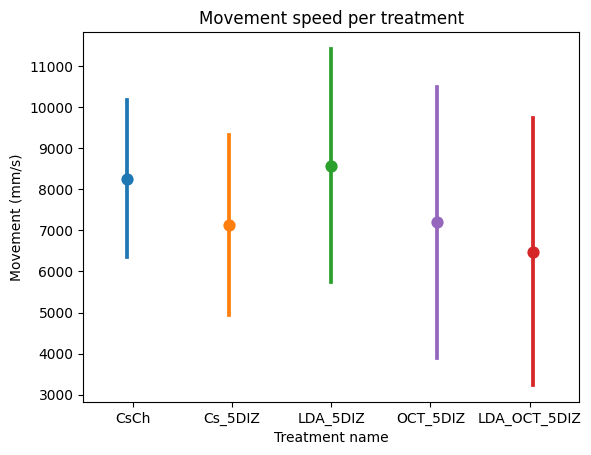

In [2]:
import os
import toml
import scipy.stats

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from statsmodels.stats.multicomp import pairwise_tukeyhsd

from src import settings
from src.utils import fileio

CONFIG_PATH = os.path.join(settings.CONFIG_DIR, "main.toml")
with open(CONFIG_PATH, "r") as file:
    config = toml.load(file)
    
TIME_WINDOW=config["TIME_WINDOW"]

INPUT_PATH = os.path.join(settings.RESULTS_DIR, "distances_traveled")

all_treatments = fileio.load_multiple_folders(INPUT_PATH)
all_treatments = {key: value for key, value in all_treatments.items() if key in config["TREATMENTS"]}

treatment_dataframes = []
for treatment_name, treatment_path in all_treatments.items():
    all_groups = fileio.load_files_from_folder(treatment_path)
    group_dataframes = []
    for group_name, df_path in all_groups.items():
        df = pd.read_csv(df_path, index_col=0)  
        df['Snapshot'] = (df.index / config["FPS"] / TIME_WINDOW).astype(int) + 1
        df['Group'] = group_name.replace(".csv","")

        group_dataframes.append(df)

    df = pd.concat(group_dataframes)
    df.set_index('Snapshot', inplace=True)
    df.set_index('Group', append=True, inplace=True)

    df['Treatment'] = treatment_name
    df.set_index('Treatment', append=True, inplace=True)
    df = df.reorder_levels(['Treatment', 'Group', 'Snapshot'])
  
    treatment_dataframes.append(df)
    
combined_data = pd.concat(treatment_dataframes)
combined_data_reset = combined_data.groupby(['Treatment', 'Group']).sum()
combined_data_reset = combined_data_reset.stack().reset_index().rename(columns={'level_2': 'Fly', 0: 'Distance'})
combined_data_reset['Distance'] = combined_data_reset['Distance'] / config['EXPERIMENT_DURATION']

treatment_sums = {}
for treatment in config["TREATMENTS"]:
    treatment_sums[f'sum_{treatment}'] = combined_data_reset[combined_data_reset['Treatment'] == treatment]['Distance']

anova_result = scipy.stats.f_oneway(*treatment_sums.values())
print(f'{anova_result}')

all_data = np.concatenate([*treatment_sums.values()])
group_labels = []
for treatment in config["TREATMENTS"]:
    group_labels.extend([treatment] * len(combined_data_reset[combined_data_reset['Treatment'] == treatment]['Distance']))

for treatment in treatment_sums.keys():
    print(f"{treatment} mean value: {np.mean(treatment_sums[treatment])} SD value: {np.std(treatment_sums[treatment])}")

tukey_results = pairwise_tukeyhsd(all_data, group_labels)
print(tukey_results)

sns.pointplot(data=combined_data_reset, x='Treatment', y='Distance', hue='Treatment', errorbar="sd", dodge=True, order=config["TREATMENTS"])

plt.title('Movement speed per treatment')
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5), title="Treatment")
plt.xlabel("Treatment name")
plt.ylabel("Movement (mm/s)")
plt.legend().remove()

sum_CsCh mean value: 8255.66520568712 SD value: 1909.8629754558176
sum_Cs_5DIZ mean value: 7124.85316904108 SD value: 2185.9087871543165
sum_LDA_5DIZ mean value: 8571.222988174326 SD value: 2835.576335886269
sum_OCT_5DIZ mean value: 7194.339655942449 SD value: 3290.4202209355717
sum_LDA_OCT_5DIZ mean value: 6483.447370427818 SD value: 3231.9681816180905
